Copyright 2021 Alexandre Marquis

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Table Of Content
* [Introduction](#first-bullet)
* [Data Analysis](#second-bullet)
    * [Expectations](#third-bullet)
    * [First Dive](#4-bullet)
    * [Missing Data](#5-bullet)
    * [Outliners removal](#out-bullet)
    * [Feature Extraction](#6-bullet)
    * [Feature Cleaning](#7-bullet)
* [Classifiers](#8-bullet)
* [Summary of what make an hit](#9-bullet)
* [Test set prediction](#10-bullet)
    
# Introduction <a class="anchor" id="first-bullet"></a>

This notebook contains my submission for Warner Media Data Science's test.
The goal was to predict if a music track would be a hit (reach the weekly list (issued by Billboards) of Hot-100 tracks) or not.
The provided dataset can be found on [Github](https://github.com/fortyTwo102/The-Spotify-Hit-Predictor-Dataset), it is composed of features such a track's metadata and musical caracteristics.

# Data Analysis <a class="anchor" id="second-bullet"></a>
## Expectations <a class="anchor" id="third-bullet"></a>

My first task was to analyse the dataset. Before looking at the samples, I started by studying the features and the impact they could have on the hit classification.

Here is a table summing my personnal analysis (before diging into the dataset) : 

| Variable         	| Type        	| Category          	| Impact Expectation 	| Comment                                                                                                                                                                                         	|
|------------------	|-------------	|-------------------	|--------------------	|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| id               	| Numerical   	| Database related  	| None               	| Unrelated to the problem.                                                                                                                                                                       	|
| track            	| Text        	| Metadata          	| Low                	| Text (can't be used in this state), maybe some words are recurrent in hit track's title. I feel like recent hits often contain words related to parties or love for example.                                  	|
| artist           	| Text        	| Metadata          	| Medium             	| I think that an artist who already did a hit has a higher probability to produce another hit.                                                                                                 	|
| uri              	| Text        	| Database related  	| None               	| Unrelated to the problem.                                                                                                                                                                       	|
| danceability     	| Numerical   	| Computed Feature  	| High               	| Lot of musics are hits because people can dance on them (at parties or at clubs for example).                                                                                                    	|
| energy           	| Numerical   	| Computed Feature  	| High               	| Same, kind of related to danceability.                                                                                                                                                          	|
| key              	| Categorical 	| Advanced Metadata 	| Low                	|                                                                                                                                                                                                 	|
| loudness         	| Numerical   	| Advanced Metadata 	| Low                	|                                                                                                                                                                                                 	|
| mode             	| Categorical 	| Advanced Metadata 	| Low                	|                                                                                                                                                                                                 	|
| speechiness      	| Numerical   	| Computed Feature  	| High               	| Tracks with speechiness too high or too low are probably less likely to be hits.                                                                                                                	|
| acousticness     	| Numerical   	| Computed Feature  	| High               	|                                                                                                                                                                                                 	|
| instrumentalness 	| Numerical   	| Computed Feature  	| High               	| Should have a negative correlation with speechiness.                                                                                                                                                         	|
| liveness         	| Numerical   	| Computed Feature  	| High               	| If the track is played live it could mean that it is one of the artist's best tracks, so more likely to be a hit.                                                                               	|
| valence          	| Numerical   	| Computed Feature  	| High               	| People like musics with high valence.                                                                                                                                                           	|
| tempo            	| Numerical   	| Advanced Metadata 	| High               	|                                                                                                                                                                                                 	|
| duration_ms      	| Numerical   	| Metadata          	| Medium             	| Longer musics are less likely to be hits (less radio broadcast).                                                                                                                     	|
| time_signature   	| Categorical 	| Advanced Metadata 	| Low                	|                                                                                                                                                                                                 	|
| chorus_hit       	| Numerical   	| Advanced Metadata 	| Low                	|                                                                                                                                                                                                 	|
| sections         	| Numerical   	| Advanced Metadata 	| Low                	| Probably correlated with duration_ms.                                                                                                                                                                                              	|
| decade          	| Categorical 	| Metadata          	| Medium             	| Can impact the way that a hit is defined, depending on the decade people had different music taste, so a music with the characteristics of a modern hit may not have been a hit 20 years ago. 	|


Now let's take a closer look to the dataset in order to see if those expectations are correct.

## First Dive <a class="anchor" id="4-bullet"></a>

Let's import the usual libraries.

In [54]:
# Classic imports
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.set()
# We disable warnings for clarity
warnings.filterwarnings('ignore')

Now we can read the data, display some samples.

In [55]:
wm_project = pd.read_csv('../input/warnermedia-project-data/WarnerMedia_project_data.csv')
display(wm_project)

# Get the index for the test samples
submission_test_indexes = wm_project[wm_project['hit'].isnull()].index

,id,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,hit,decade
0,0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.000000,0.1590,0.532,133.061,196707,4,30.88059,13,1.0,2000
1,1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.000000,0.1480,0.688,92.988,242587,4,41.51106,10,NaN,2000
2,2,Clouds Of Dementia,Candlemass,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.004570,0.1740,0.300,86.964,338893,4,65.32887,13,0.0,2000
3,3,"Heavy Metal, Raise Hell!",Zwartketterij,spotify:track:2IjBPp2vMeX7LggzRN3iSX,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.078400,0.1920,0.333,148.440,255667,4,58.59528,9,0.0,2000
4,4,I Got A Feelin',Billy Currington,spotify:track:1tF370eYXUcWwkIvaq3IGz,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.000000,0.1250,0.631,112.098,193760,4,22.62384,10,1.0,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41101,41101,(You're A) Go Nowhere,Reagan Youth,spotify:track:4e86fqSFhqRQk3Z9hm7XHt,0.396,0.795,9,-6.070,0,0.2340,0.000928,0.000209,0.1820,0.762,152.943,82107,4,30.34109,6,0.0,1990
41102,41102,La Fiebre de Norma,La Castañeda,spotify:track:43DFcnOZprnVlAFKwgBJ3e,0.621,0.655,9,-6.281,0,0.0309,0.050600,0.006260,0.0937,0.690,134.167,211653,4,34.89506,10,0.0,1990
41103,41103,Good Times,Edie Brickell,spotify:track:6UPfnVoOq3y3BvapBIKs8J,0.562,0.314,10,-15.213,0,0.0298,0.440000,0.000011,0.1060,0.571,166.847,189827,4,21.11763,10,1.0,1990
41104,41104,Inane,KMFDM,spotify:track:2Ao3Wi4raEOQfKQiU9EU8y,0.622,0.781,7,-6.080,1,0.0368,0.000101,0.755000,0.3830,0.214,120.051,330053,4,47.13558,11,0.0,1990


We can explore the dataset and retreive interesting informations like the artist with the higher number of  hits and the artist with the higher number of tracks for example. I also plotted the number of track by decade.

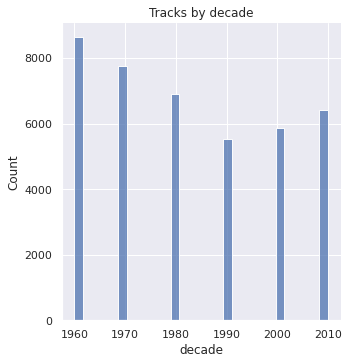

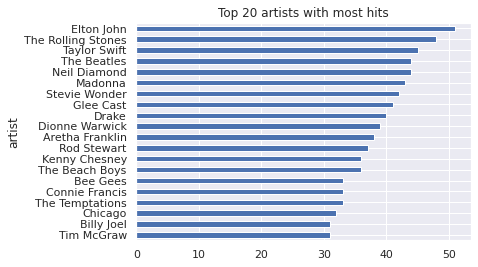

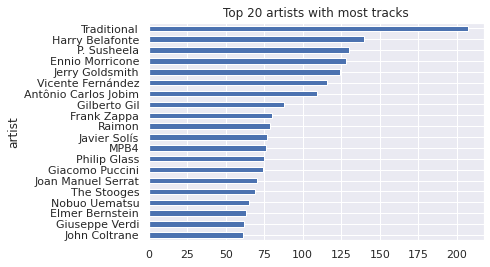

In [56]:
sns.displot(wm_project['decade']).set(title='Tracks by decade')
plt.show()
wm_project.groupby('artist').sum()['hit'].sort_values(ascending=True)[-20:].plot.barh(title='Top 20 artists with most hits')
plt.show()
wm_project.groupby('artist').count()['id'].sort_values(ascending=True)[-20:].plot.barh(title='Top 20 artists with most tracks');

We can also access typical statistics of the dataset to have a global idea of each feature.

In [57]:
wm_project[wm_project['hit'].notnull()].describe().T

,count,mean,std,min,25%,50%,75%,max
id,33707.0,20589.295962,11861.120560,0.000000,10298.500000,20609.000000,30891.500000,41105.000
danceability,33707.0,0.539300,0.178031,0.000000,0.420000,0.552000,0.669000,0.988
energy,33707.0,0.578931,0.252921,0.000251,0.396000,0.601000,0.786000,1.000
key,33707.0,5.209274,3.534698,0.000000,2.000000,5.000000,8.000000,11.000
loudness,33707.0,-10.237281,5.324976,-49.253000,-12.831000,-9.270000,-6.389000,3.744
mode,33707.0,0.694069,0.460807,0.000000,0.000000,1.000000,1.000000,1.000
speechiness,33707.0,0.072542,0.085173,0.000000,0.033700,0.043400,0.069500,0.960
acousticness,33707.0,0.366281,0.339127,0.000000,0.040300,0.262000,0.678000,0.996
instrumentalness,33707.0,0.155126,0.304373,0.000000,0.000000,0.000124,0.061300,1.000
liveness,33707.0,0.201256,0.172865,0.013000,0.093900,0.132000,0.261000,0.999


We can start by plotting the correlation matrix in order to see the correlation between each variable and the correlation between the label and the features.

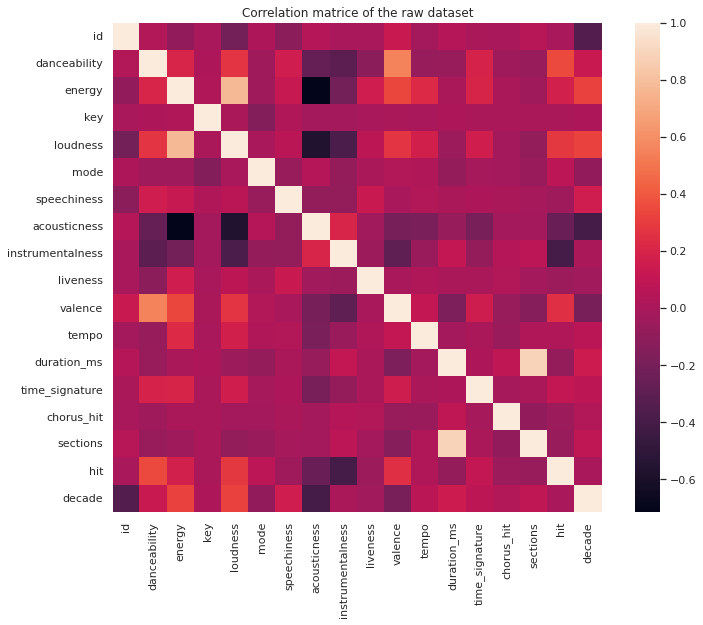

In [58]:
corrmat = wm_project.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True).set(title='Correlation matrice of the raw dataset');

Here we can extract some important informations from this matrix :
* sections and duration_ms are highly correlated
* energy and loudness are correlated
* acousticness have a negative correlation with energy and loudness
* valence, instrumentalness, danceability seems to have a high impact on if a track is or isn't a hit

However here the categorical variables are not processed and represented as numerical values, we will study them in depth later.
Now let's see how the decade impact the "definition" of a hit.

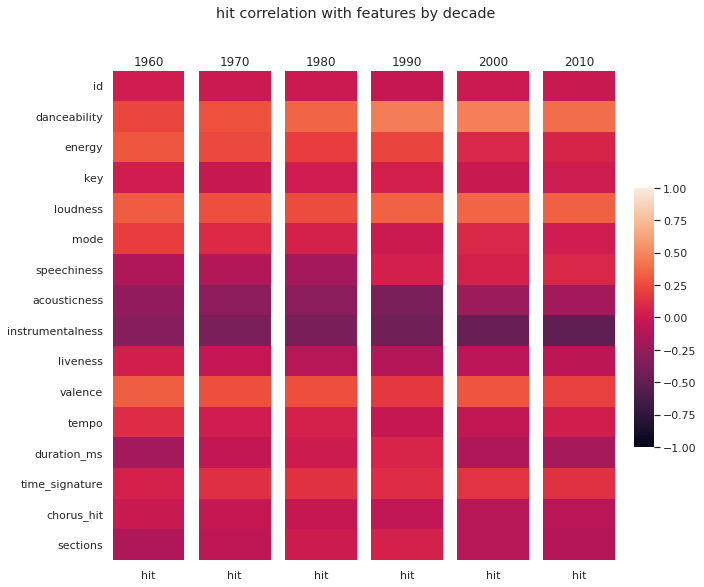

In [59]:
decades = wm_project['decade'].unique()
decades.sort()
fig, axn = plt.subplots(1, len(decades), sharex=True, sharey=True, figsize=(9, 9))
cbar_ax = fig.add_axes([0.93, .3, .03, .4])
plt.suptitle("hit correlation with features by decade")

for i, ax in enumerate(axn.flat):
    corrmat = wm_project[wm_project['decade'] == decades[i]].corr()['hit'][:-2]
    sns.heatmap(corrmat.to_frame(), ax=ax, cbar=i == 0,
                cbar_ax=None if i else cbar_ax, vmin=-1, vmax=1)
    ax.set_title(decades[i])

We can confirm that the definition of a hit change with the decade, for example now danceability, speechiness and duration_ms have a different impact than in the 60s. In order to reflect this change my solution would be to use a different predictor for each decade. 
Now let's do a pair plot of the variables that seem to have the biggest influence on the classification.

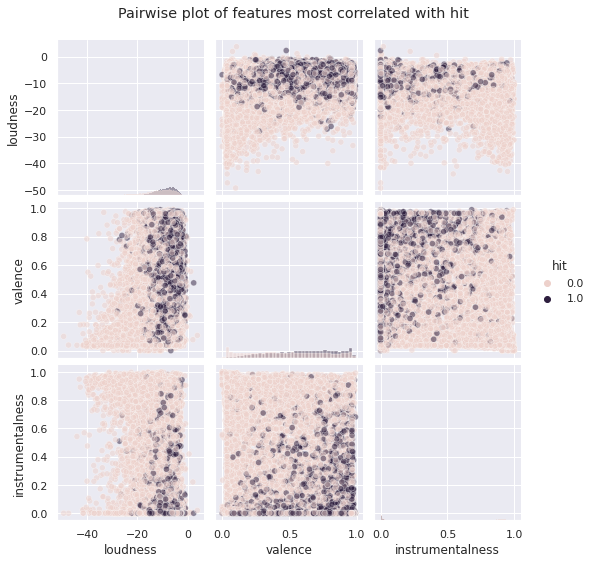

In [60]:
cols = set(['valence', 'loudness', 'instrumentalness', 'hit'])
g = sns.pairplot(wm_project[cols],hue = 'hit', diag_kind= 'hist',
             vars=wm_project[cols - set(['hit'])],
             plot_kws=dict(alpha=0.5))
g.fig.suptitle('Pairwise plot of features most correlated with hit', y=1.04);

We can see the influence that variables have on each other and also the shape of their distributions (we will study them in depth later).
With all those informations we can start extracting the correct features and droping thoses which are not useful.

We can also compare the musical caracteristics of hits and flops by comparing their distributions.
On the violon graph below we can see that hits tends to have a higher valence and danceability, but a lower energy.

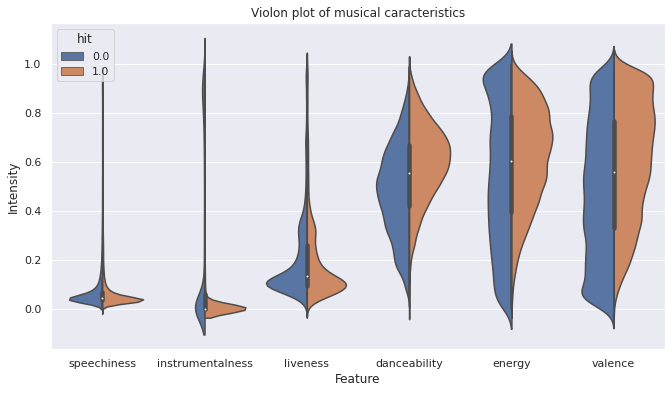

In [61]:
cols = ['speechiness', 'instrumentalness', 'liveness', 'danceability', 'energy', 'valence', 'hit']
violon_frame = wm_project.loc[wm_project['hit'].notnull(), cols]
violon_frame = violon_frame.melt(id_vars='hit', var_name='Feature', value_name='Intensity')
f, ax = plt.subplots(figsize=(11, 6))
sns.violinplot(x='Feature', y='Intensity', hue="hit",  data=violon_frame, split=True).set(title='Violon plot of musical caracteristics');


## Missing Data <a class="anchor" id="5-bullet"></a>

Let's see where are the missing data in the dataset.

In [62]:
display(wm_project.isnull().sum().sort_values(ascending=False).head())
print('Rows with missing key : ', wm_project[wm_project['key'] == -1].size)

hit            7399
decade            0
speechiness       0
track             0
artist            0
dtype: int64

Rows with missing key :  0


There seems to be no missing data (excluding the hit prediction that need to be done).

## Outliners removal <a class="anchor" id="out-bullet"></a>

After this analysis I decided to remove outliners from the dataset. First I looked more carefully at the data distribution of the numerical values.

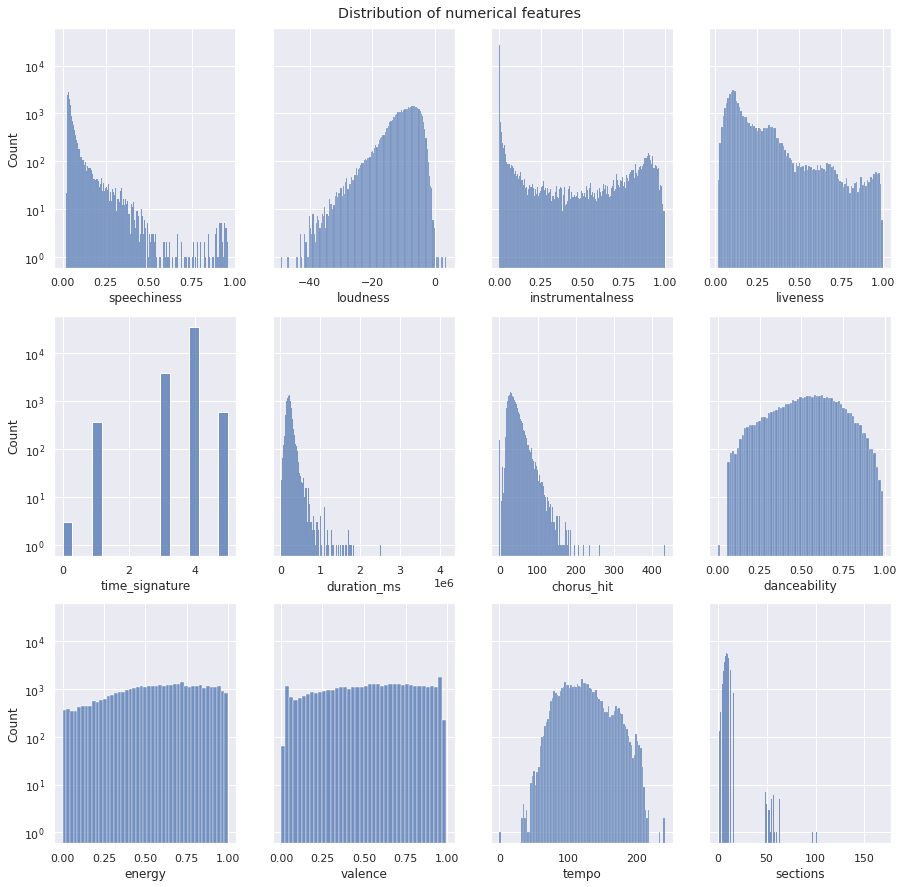

In [63]:
fig, axn = plt.subplots(3, 4, sharey=True, figsize=(15, 15))
plt.suptitle("Distribution of numerical features", y=0.9)
cols = ['speechiness', 'loudness', 'instrumentalness', 'liveness', 'time_signature',
        'duration_ms', 'chorus_hit', 'danceability', 'energy', 'valence', 'tempo', 'sections']
for i, col in enumerate(cols):
    sns.histplot(wm_project[col], log_scale=(0, 10), ax=axn.flat[i])
plt.show()

Here we can clearly see the outliners : 
- loudness above 0 (should be impossible)
- duration above 2000 secondes
- chorus_hit above 300
- danceability at 0
- tempo at 0 or above 230
- speechiness equal to 0

We can remove them from the dataset. We do not change "sections" as it will be removed from the dataset since it is highly correlated with duration_ms.
Strangely there is no sample with a time_signature of 2, but it should not be a problem.

In [64]:
# We do not change the original dataset
df = wm_project.copy()

# We remove the test samples
df = df.dropna()

df = df[df['speechiness'] != 0]
df = df[df['loudness'] < 0]
df = df[(df['tempo'] < 230) & (df['tempo'] > 0)]
df = df[df['duration_ms'] < 2000000]
df = df[df['time_signature'] != 0]
df = df[df['chorus_hit'] <= 300]
df = df[df['danceability'] != 0]

## Feature Extraction <a class="anchor" id="6-bullet"></a>

As I didn't want to simply remove the "artist" and "track" features, I came with multiple ideas to include some of their information in the features.

First for the track title, I decided to create a field that indicate wether the title is in english or not. I did this because what define a hit is wether it reach the US top 100 or not, and english musics are more likely to reach it in an english speaking country. I did this by using a model from the fasttext library.

Secondly, I think that hits usually have a title that transmit a positive feeling, so in order to extract that I used the sentiment analyzer from the NLTK library and added the sentiment (between 'positive', 'neutral', 'negative' 'compound') with the highest presence as a feature.

In [65]:
# Install required libraries and download the fasttext model
!pip install fasttext nltk
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz

--2021-11-15 11:56:59--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 938013 (916K) [binary/octet-stream]
Saving to: ‘lid.176.ftz.4’

lid.176.ftz.4       100%[===================>] 916.03K  2.27MB/s    in 0.4s    

2021-11-15 11:57:00 (2.27 MB/s) - ‘lid.176.ftz.4’ saved [938013/938013]



In [66]:
import fasttext, nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

#Remove warning
fasttext.FastText.eprint = lambda x: None

sia = SentimentIntensityAnalyzer()
langage_predictor = fasttext.load_model('lid.176.ftz')

def get_sen(x):
    sen = sia.polarity_scores(x)
    return max(sen, key=sen.get)

df['sen'] = df['track'].apply(get_sen)
df['is_english'] = df['track'].apply(lambda w: langage_predictor.predict(w, k=1)[0][0] == '__label__en')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Now let's see if the classification really change depending on those new features.

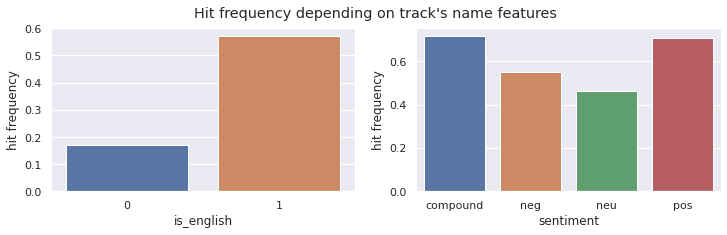

In [67]:
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(12, 3))
plt.suptitle("Hit frequency depending on track's name features")
sns.barplot(x = [0, 1],
            y = df[df['hit'] == 1].groupby('is_english').size()/df.groupby('is_english').size(),
            ax = ax0)
ax0.set(xlabel='is_english', ylabel='hit frequency')
sns.barplot(x = sorted(df['sen'].unique()),
            y = df[df['hit'] == 1].groupby('sen').size()/df.groupby('sen').size(),
            ax = ax1)
ax1.set(xlabel='sentiment', ylabel='hit frequency');

Those bargraphs show that the langage have a huge influence on the classification of the track and the sentiment has a smaller (but not negligeable) influence.

The next step was to include informations from the author inside the dataset. As I said in the first part, I think that an artist that already released a hit is more likely to release another hit. We can see this on the next graph, where either 0% or 100% of the author's tracks are hits.

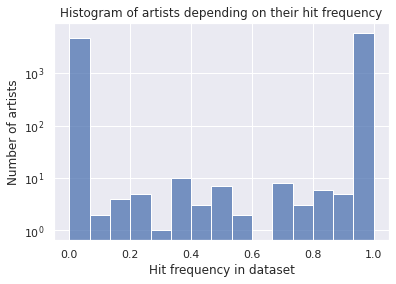

In [68]:
freq_hits = wm_project.groupby('artist').sum()['hit']/wm_project[wm_project['hit'].notnull()].groupby('artist').size()
sns.histplot(freq_hits, log_scale=(0, 10)).set(title = 'Histogram of artists depending on their hit frequency')
plt.xlabel('Hit frequency in dataset')
plt.ylabel('Number of artists');

In order to include that I decided to add as a feature the number of hits already released by an artist.

However, we have to be careful here in order to prevent any data leak (train or test on data that should not have been seen by the model), so I first splitted the dataset into a train set and a validation set, and for each track I only added the number of hits made by the same artist in the previous decade and contained in the train set (with a more precise release date this feature could be more powerful, we could take all hits realased by the author before the concerned track, not only from the previous decade).

Last but not least, I also added a feature indicating if the author already released a song the previous decade or not. I did it so that if an author did not release a hit the previous decade but did release a track, it is not the same that if he did not release any track at all (something that isn't represented by the other feature).

In [69]:
from sklearn.model_selection import train_test_split, cross_validate

train_indexes, val_indexes = train_test_split(df.index)

In [70]:
def get_previous_hits_nb(row):
    try:
        return dec_hits[row['decade']].xs(row['artist'])
    except:
        return 0
    

df_train = df.loc[train_indexes]
dec_hits = {}

# We prepare a dictionnary with the numbe rof hits by artist released before each decade
for dec in decades:
    dec_hits[dec] = df_train[df_train['decade'] < dec].groupby('artist').sum()['hit']
    
df['nb_hits_author'] = df.apply(get_previous_hits_nb, axis=1)
df['first_song'] = df.apply(lambda row: not row['artist'] in dec_hits[row['decade']].index, axis=1)
df['is_feat'] = df.apply(lambda row: ('feat' in row['artist'].lower()) or ('feat' in row['track'].lower()), axis=1)

1352
139
16759
15437


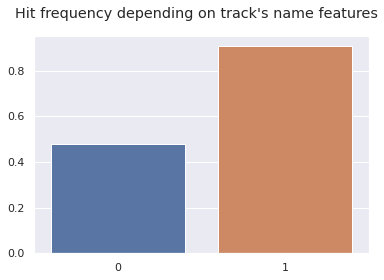

In [71]:
print(len(df[(df['is_feat'] == 1) & (df['hit'] == 1)]))
print(len(df[(df['is_feat'] == 1) & (df['hit'] == 0)]))
print(len(df[(df['is_feat'] == 0) & (df['hit'] == 0)]))
print(len(df[(df['is_feat'] == 0) & (df['hit'] == 1)]))
plt.suptitle("Hit frequency depending on track's name features")
sns.barplot(x = [0, 1],
            y = df[df['hit'] == 1].groupby('is_feat').size()/df.groupby('is_feat').size())

## Feature Cleaning <a class="anchor" id="7-bullet"></a>

The last step here is to clean our remaining features, meaning correctly transforming the categorical features and droping the features that seem unecessary.
First let's take a look at the categorical features.

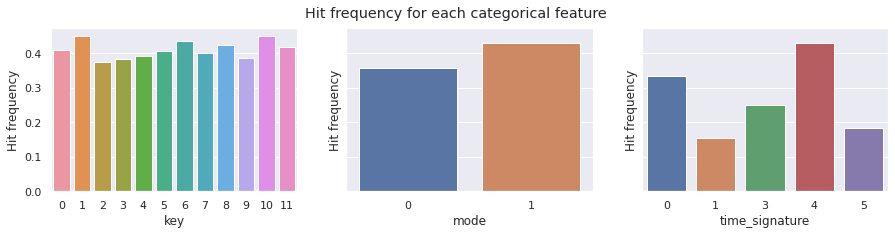

In [72]:
# Decade ignored on purpose
cols = ['key', 'mode', 'time_signature']
fig, axn = plt.subplots(1, len(cols), sharey=True, figsize=(15, 3))
plt.suptitle('Hit frequency for each categorical feature')
for i, col in enumerate(cols):
    ax = sns.barplot(x = sorted(wm_project[col].unique()), 
                     y = wm_project[wm_project['hit'] == 1].groupby(col).size()/wm_project.groupby(col).size(),
                     ax = axn[i])
    ax.set(xlabel=col, ylabel="Hit frequency")
plt.show()

On those bar graphs we can see that in fact "key" does not seem to really impact the hit frequency while the impact of mode is superior and the impact of time_singature is even greater. We can drop the key feature but keep the two other ones for now.

*After some trials and errors, it seems that "mode" and "time_signature" can be removed too, it is explained later in the notebook.*

danceability        float64
energy              float64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
chorus_hit          float64
hit                 float64
decade                int64
is_english             bool
nb_hits_author      float64
first_song             bool
is_feat                bool
dtype: object

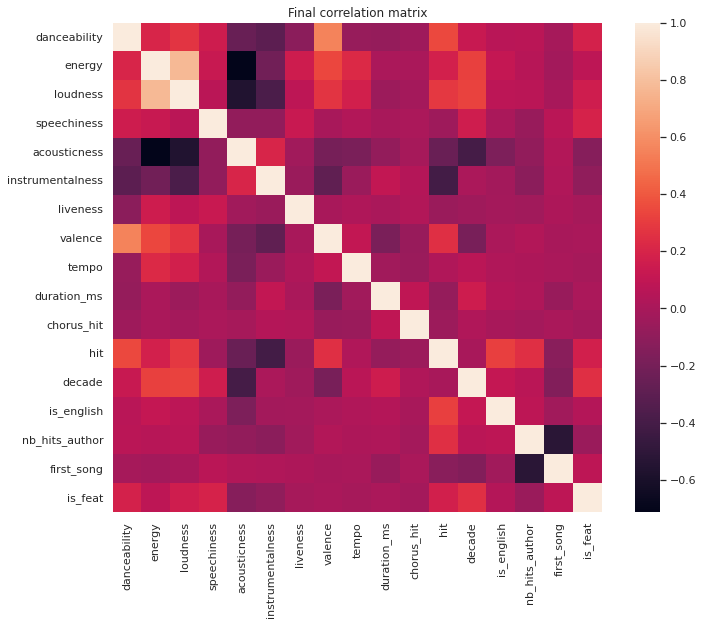

In [73]:
# Drop the unused features
df_final = df.drop(['id', 'track', 'uri', 'sections', 'key', 'artist', 'mode', 'sen', 'time_signature'], axis=1)

# Convert to categorical
#df_final['time_signature'] = df['time_signature'].astype('category')
display(df_final.dtypes)

#No need anymore, no categorical feature used
#df_final = pd.get_dummies(df_final)

corrmat = df_final.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True).set(title='Final correlation matrix');

This final correlation matrix is way clearer. The only unnecessary correlation remaining is between energy, loudness and accousticness, but after multiple tries every one of them seems to bring information to the model.

We can now take a final last look at our processed dataset to check that everything seems fine.

In [74]:
df_train = df_final.loc[train_indexes]
df_val = df_final.loc[val_indexes]
X_train = df_train.loc[:, df_train.columns != 'hit']
X_val = df_val.loc[:, df_val.columns != 'hit']
y_train = df_train['hit']
y_val = df_val['hit']
pd.set_option('display.max_columns', None)
display(X_val)
display(y_val)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,chorus_hit,decade,is_english,nb_hits_author,first_song,is_feat
23912,0.525,0.735,-8.303,0.0377,0.1320,0.534000,0.0667,0.947,112.007,453267,19.60945,1970,True,1.0,False,False
14309,0.200,0.269,-14.245,0.0295,0.5540,0.005330,0.1040,0.122,83.560,161547,57.84251,1960,True,0.0,True,False
33888,0.491,0.837,-5.190,0.0441,0.1430,0.004560,0.2840,0.766,128.002,151901,22.47409,1980,True,0.0,True,False
18462,0.332,0.495,-11.345,0.0348,0.6300,0.000001,0.3270,0.658,113.194,170307,45.87437,1960,True,0.0,True,False
2597,0.384,0.581,-8.881,0.0335,0.4730,0.007780,0.1140,0.208,123.081,368320,67.15320,2000,True,0.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38643,0.632,0.610,-10.201,0.0346,0.0355,0.010500,0.2020,0.548,124.135,198200,16.84840,1990,False,0.0,True,False
30586,0.743,0.291,-13.390,0.1120,0.9920,0.002130,0.2820,0.639,82.917,223027,22.26247,1980,True,0.0,True,False
31385,0.448,0.612,-6.951,0.0366,0.0288,0.000000,0.1100,0.537,158.220,231907,45.39349,1980,True,5.0,False,False
29612,0.504,0.792,-11.639,0.0423,0.0765,0.011100,0.3800,0.631,102.676,127013,108.57534,1980,True,0.0,True,False


23912    1.0
14309    0.0
33888    1.0
18462    1.0
2597     0.0
        ... 
38643    0.0
30586    0.0
31385    1.0
29612    0.0
15313    0.0
Name: hit, Length: 8422, dtype: float64

# Classifiers <a class="anchor" id="8-bullet"></a>

Now that we have our dataset with hand made features, we can try multiple usual classifiers to see wich one is the best for our problem. I only tried models that could be easily interpreted (no deep neural networks).

In order to compare models, we need to have correct metrics. In the dataset, the number of hit and flop is balanced, so  accuracy should work great here. I also decided to use precision, recall and f1 for good measure.

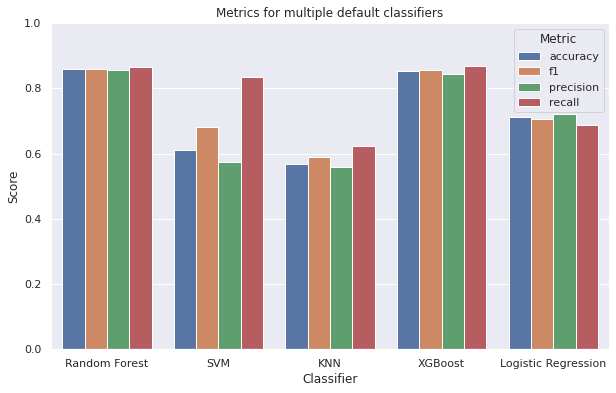

In [75]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 

def get_scores(y_true, y_pred, name="Unamed"):
    score = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
    }
    score = pd.Series(score)
    score.name = name
    return score
     
classifiers = {
    'Random Forest' : RandomForestClassifier(),
    'SVM' : SVC(),
    'KNN' : KNeighborsClassifier(),
    'XGBoost' : GradientBoostingClassifier(),
    'Logistic Regression' : LogisticRegression(solver='liblinear'), # The default solver caused a bug on my kernel
}

scores = pd.DataFrame()

for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_val)
    score = get_scores(y_val, y_pred, name=name)
    scores = scores.append(score)
    
barplot_frame = scores.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
barplot_frame = barplot_frame.rename(columns={"index": "Classifier"})
fig, ax = plt.subplots(figsize=(10,6))
g = sns.barplot(y='Score', hue='Metric', x='Classifier', data= barplot_frame).set(title="Metrics for multiple default classifiers", ylim=(0, 1));

As expected, ensemble classifiers have better scores. Of course we could carefully choose each parameter for each classifier in order to improve the prediction, but as random forest are known to work well on those kind of problem, I decided to stick to this classifier.

In order to visualize the quality of our predictions, the confusion matrix could be helpful.

accuracy     0.859772
precision    0.855055
recall       0.865045
f1           0.860021
Name: Metrics, dtype: float64

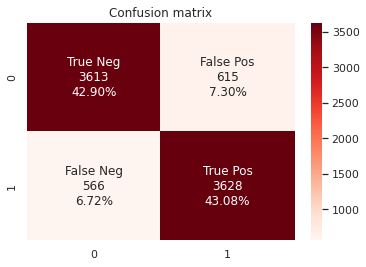

In [76]:
from sklearn.metrics import confusion_matrix

rf_classifier = classifiers['Random Forest']
y_pred = rf_classifier.predict(X_val)

def display_scores_confmat(y_true, y_pred):
    score = get_scores(y_true, y_pred, "Metrics")
    display(score)
    cf_matrix = confusion_matrix(y_true, y_pred)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds').set(title="Confusion matrix");

display_scores_confmat(y_val, y_pred)  

Now let's try the idea of using one classifier by decade and see the results.

accuracy     0.870221
precision    0.866809
recall       0.873629
f1           0.870205
Name: Metrics, dtype: float64

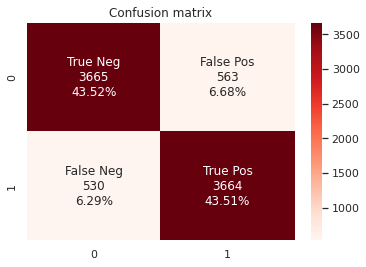

In [77]:
ind_scores = pd.DataFrame()
common_scores = pd.DataFrame()

decade_classifiers = {}

total_preds = []
total_true = []

for decade in decades:
    ind_rf_classifier = RandomForestClassifier(n_estimators=160, max_depth=22) #Parameters selected via GridSerarch, see next cell
    train_indexes = X_train[X_train['decade'] == decade].index
    val_indexes = X_val[X_val['decade'] == decade].index
    y_true = y_val.loc[val_indexes]
    
    ind_rf_classifier.fit(X_train.loc[train_indexes].drop('decade', axis=1), y_train.loc[train_indexes])
    
    ind_y_pred = ind_rf_classifier.predict(X_val.loc[val_indexes].drop('decade', axis=1))
    common_y_pred = rf_classifier.predict(X_val.loc[val_indexes])
    
    total_preds.extend(ind_y_pred)
    total_true.extend(y_true)
    
    ind_score = get_scores(y_true, ind_y_pred, decade)
    ind_scores = ind_scores.append(ind_score)
    common_score = get_scores(y_true, common_y_pred, decade)
    common_scores = common_scores.append(common_score)
    decade_classifiers[decade] = ind_rf_classifier

display_scores_confmat(total_true, total_preds)

It is also interesting to look at the ROC curve, it explains clearly the tradeoff between precision and recall, depending on our objective it might be interesting to slightly modify the treshold of the random forest in order to improve one metric (and decrease the other).

AUC of ROC 0.936029147374115


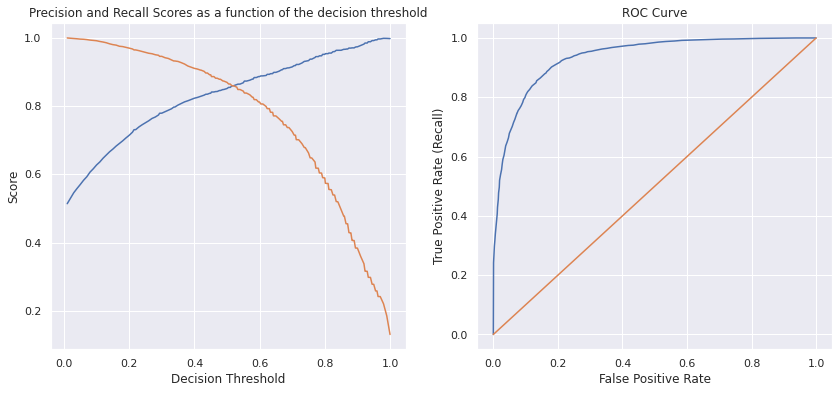

In [78]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

probs = rf_classifier.predict_proba(X_val)[:, 1]
prec, rec, thresh = precision_recall_curve(y_val, probs)

fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(14, 6))
ax0.set_title("Precision and Recall Scores as a function of the decision threshold")
ax0.plot(thresh, prec[:-1], label="Precision")
ax0.plot(thresh, rec[:-1], label="Recall")
ax0.set_ylabel("Score")
ax0.set_xlabel("Decision Threshold")

fpr, tpr, auc_thresholds = roc_curve(y_val, probs)
print('AUC of ROC', auc(fpr, tpr))

ax1.set_title('ROC Curve')
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1])
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate (Recall)");

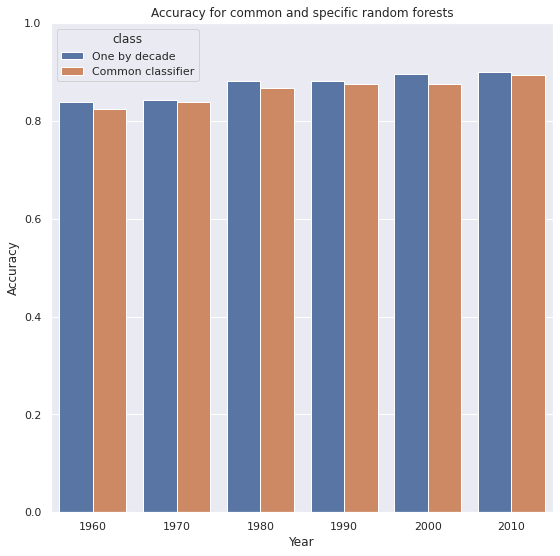

In [79]:
ind_scores['class'] = 'One by decade'
common_scores['class'] = 'Common classifier'
scores_ind_cm = pd.concat([ind_scores, common_scores])
barplot_frame2 = scores_ind_cm.reset_index().melt(id_vars=['index', 'class'], var_name='Metric', value_name='Score')
barplot_frame2 = barplot_frame2.rename(columns={"index": "Year"})
barplot_frame2 = barplot_frame2[barplot_frame2['Metric'] == 'accuracy']
fig, ax = plt.subplots(figsize=(9,9))
g = sns.barplot(y='Score', hue='class', x='Year', data= barplot_frame2).set(title='Accuracy for common and specific random forests')
plt.ylim((0, 1))
plt.ylabel('Accuracy');

We can see that this technique improve the result a bit.

The next step is to find the correct values of the hyper parameters. In order to do that we will simply do a grid search. This step can take long time so we will limit the search to a reduced area.

In [80]:
from sklearn.model_selection import GridSearchCV

computer_best_parameters = False
if computer_best_parameters :
    parameters = {'n_estimators': range(120, 180, 20), 'max_depth':range(15, 25)}
    clf = GridSearchCV(rf_classifier, parameters)
    clf.fit(X_train, y_train)
    print('Best params : ')
    print(clf.best_params_)
else:
    print('Best parameters not computed (change variable too activate it, it can be long).')

Best parameters not computed (change variable too activate it, it can be long).


# Summary of what make an hit <a class="anchor" id="9-bullet"></a>

Now that we have a good classifier (with around 86% of accuracy), we can try again to determinate what are the most important features that make a hit.
To do that we will take a look at the feature importance of each random forest.

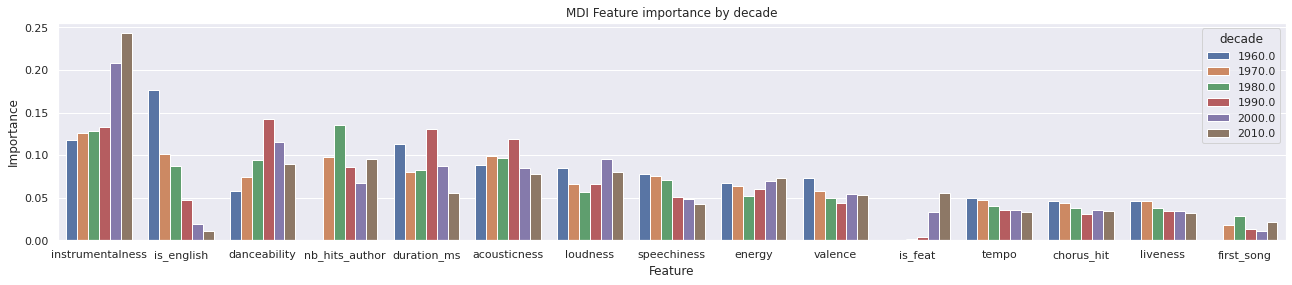

In [81]:
feature_names = X_train.drop('decade', axis=1).columns
features_importances = pd.DataFrame(columns=feature_names)

for decade in decades:
    importances = decade_classifiers[decade].feature_importances_
    importances = pd.Series(importances, index=feature_names)
    importances['decade'] = decade
    features_importances = features_importances.append(importances, ignore_index=True)

features_importances = features_importances.melt(id_vars='decade', var_name='Feature', value_name='Importance')
features_importances = features_importances.sort_values('Importance', ascending=False)
fig, ax = plt.subplots(figsize=(22,4))
sns.barplot(y='Importance', hue='decade', x='Feature', data= features_importances).set(title='MDI Feature importance by decade');

Here we can highlight lot of interesting phenomena:
- The importance of each feature vary quite a lot depending on the decade
- In 1960, the langage of the track impacted a lot its chances of being a hit, but the importance of this feature decreased a lot and is now close to 0. That may be why we gained a lot in accuracy for the early decades by using a different classifier for each decade.
- On the contrary, instrumentalness gained a lot of importance and is now the most importante feature by far, it could mean that now people pay more attention to the instruments or lyrics in a song (probably the lyrics since there is an inverse correlation between "hit" and "instrumentalness")
- The number of hits already released by an artist is also very important, as expected since when you already made a hit more people will listen to your new songs and they will have a better chance to become a hit.
- The danceability, duration and accousticness are of course really important to make a hit, the music must be short/long enough to be broadcast at the radio, have a high danceability to be played at parties and a good accousticness
- Last but not least, this graph helped me realize that the sentiment feature that I implemented didn't have a lot of importance so I removed it. I think that instead of sentiment, the main theme could be more useful.

Let's see with an example : Hello Goodbye by The Beatles (that is a hit), we can vizualize the Shapley values and see how each feature affect the classifier's decision.

In [82]:
!pip install shap
import shap

shap.initjs()
sample_id = 14111
sample = wm_project[wm_project['id'] == sample_id]
print(sample['track'].item(), 'by', sample['artist'].item())

explainer = shap.TreeExplainer(decade_classifiers[1960])
try :
    choosen_instance = X_train.loc[sample_id].drop('decade')
except:
    choosen_instance = X_val.loc[sample_id].drop('decade')
    
shap_values = explainer.shap_values(choosen_instance)
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

     |████████████████████████████████| 371 kB 4.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509257 sha256=615f47d71cc17b3ff1e17c4519c35e8850a6b1499420746723cf66349b8aded4
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


Hello Goodbye by The Beatles


We can also observe the Shapley values for multiple samples.

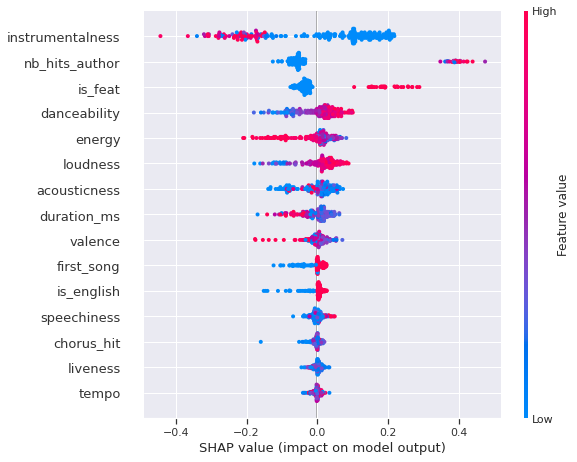

In [83]:
explainer = shap.TreeExplainer(decade_classifiers[2010])
shap_values = explainer.shap_values(X = X_train[X_train['decade'] == 2010][:200].drop('decade', axis=1))
shap.summary_plot(shap_values = shap_values[1], 
                  features = X_train[X_train['decade'] == 2010].iloc[:200].drop('decade', axis=1))

Or we can study the interaction between two features.

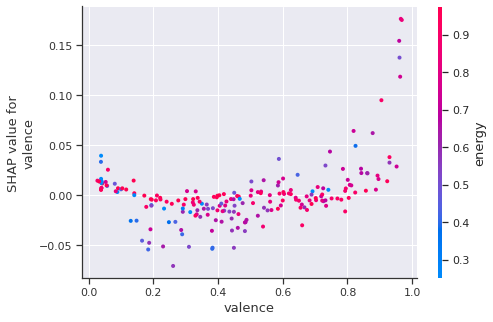

In [84]:
shap.dependence_plot("valence",shap_values[0], X_train[X_train['decade'] == 2010].iloc[:200].drop('decade', axis=1))

In order to understand our classifiers, we can plot one of the trees. This tree is really big (max_depth = 22, here we only plot the 5 first floors), but it is interesting to understand how the tree will make the classification.

In [85]:
!pip install graphviz

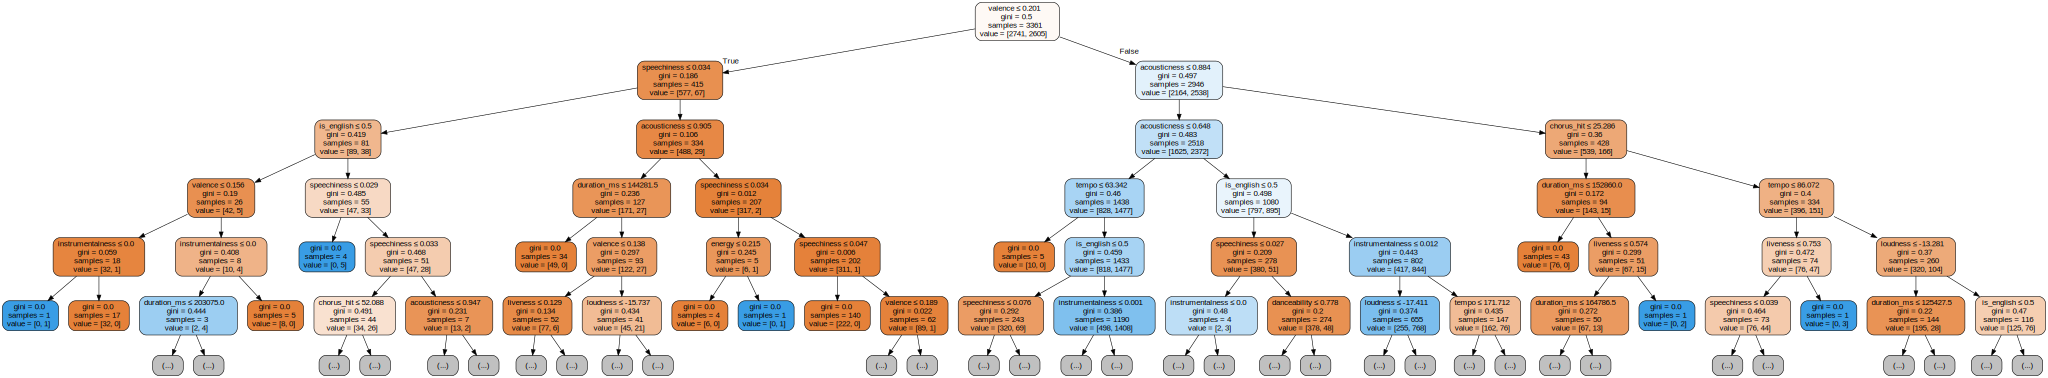

In [86]:
from sklearn.tree import export_graphviz
import graphviz

graph = export_graphviz(decade_classifiers[1960].estimators_[0], max_depth=5,
                        feature_names=X_train.drop('decade', axis=1).columns,
                        out_file=None, filled=True, rounded=True, special_characters=True)

graphviz.Source(graph)

# Test set prediction <a class="anchor" id="10-bullet"></a>

The final part of this test will be to make the prediction on the test set. First I will retrain the model on the whole set (train + validation) in order to produce the best prediction for the test set. 

Here we repeat all the important steps to process the data. I could have created functions to do that with a one-liner, but I think it is important to have a cell where we redo the whole process.

In [87]:
wm_project_completed = wm_project.copy()
df_final_pred = wm_project.copy()

# Remove outliners from train set
df_final_pred = df_final_pred[(df_final_pred['speechiness'] != 0) | (df_final_pred['hit'].isnull())]
df_final_pred = df_final_pred[(df_final_pred['loudness'] < 0) | (df_final_pred['hit'].isnull())]
df_final_pred = df_final_pred[((df_final_pred['tempo'] < 230) & (df_final_pred['tempo'] > 0)) | (df_final_pred['hit'].isnull())]
df_final_pred = df_final_pred[(df_final_pred['duration_ms'] < 2000000) | (df_final_pred['hit'].isnull())]
df_final_pred = df_final_pred[(df_final_pred['time_signature'] != 0) | (df_final_pred['hit'].isnull())]
df_final_pred = df_final_pred[(df_final_pred['chorus_hit'] <= 300) | (df_final_pred['hit'].isnull())]
df_final_pred = df_final_pred[(df_final_pred['danceability'] != 0) | (df_final_pred['hit'].isnull())]
df_train_pred = df_final_pred[df_final_pred['hit'].notnull()]

# Add is_english feature
df_final_pred['is_english'] = df_final_pred['track'].apply(lambda w: langage_predictor.predict(w, k=1)[0][0] == '__label__en')

# Add nb_hits_author and first_song features
dec_hits = {}
for dec in decades:
    dec_hits[dec] = df_train_pred[df_train_pred['decade'] < dec].groupby('artist').sum()['hit'] 
    
df_final_pred['nb_hits_author'] = df_final_pred.apply(get_previous_hits_nb, axis=1)
df_final_pred['first_song'] = df_final_pred.apply(lambda row: not row['artist'] in dec_hits[row['decade']].index, axis=1)

# Drop unused features
df_final_pred = df_final_pred.drop(['id', 'track', 'uri', 'sections', 'key', 'artist', 'time_signature', 'mode'], axis=1)

X_test = df_final_pred.loc[submission_test_indexes].drop(['hit'], axis=1)
X_train_pred = df_final_pred.loc[df_final_pred['hit'].notnull(), df_final_pred.columns != 'hit']
y_train_pred = df_final_pred.loc[df_final_pred['hit'].notnull(), df_final_pred.columns == 'hit']

# Train and do prediction
for decade in decades:
    clf = RandomForestClassifier(n_estimators=160, max_depth=22)
    train_indexes = X_train_pred[X_train_pred['decade'] == decade].index
    test_indexes = X_test[X_test['decade'] == decade].index
    clf.fit(X_train_pred.loc[train_indexes].drop('decade', axis=1), y_train_pred.loc[train_indexes])
    wm_project_completed.loc[test_indexes, 'hit'] = clf.predict(X_test.loc[test_indexes].drop(['decade'], axis=1))

wm_project_completed['hit'] = wm_project_completed['hit'].astype('int')
wm_project_completed.to_csv('completed_dataset.csv', index=False)